# Wild Life Inference

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!unrar x /content/drive/MyDrive/Dataset.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/Dataset.rar

Creating    Dataset                                                   OK
Creating    Dataset/elephant                                          OK
Extracting  Dataset/elephant/001.jpg                                       0%  OK 
Extracting  Dataset/elephant/001.txt                                       0%  OK 
Extracting  Dataset/elephant/002.jpg                                       0%  OK 
Extracting  Dataset/elephant/002.txt                                       0%  OK 
Extracting  Dataset/elephant/003.jpg                                       0%  OK 
Extracting  Dataset/elephant/003.txt                                       0%  OK 
Extracting  Dataset/elephant/004.jpg                                       0%  OK 
Extracting  Dataset/elephant/004.txt                                       0%

In [3]:
!pip install -q timm pytorch_lightning
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets evaluate
!pip install accelerate -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 15.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29

In [4]:
import os, gc, sys, io
from pathlib import Path
import glob
from tqdm.auto import tqdm
tqdm.pandas()

import PIL
import cv2

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import utils
from torchvision import transforms as T
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import torchmetrics
import timm

In [5]:
from google.colab import userdata
token = userdata.get('HF_TOKEN')

In [6]:
# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

INFO:lightning_fabric.utilities.seed:Seed set to 42


Device: cuda:0


In [7]:
CHECKPOINT = "/content/drive/MyDrive"

DATA_PATH = Path("Dataset")
RANGER_PATH = DATA_PATH/"Ranger"
ELEPHANT_PATH = DATA_PATH/'elephant'
RHINO_PATH = DATA_PATH/"rhino"

os.listdir(DATA_PATH)

['Ranger', 'elephant', 'rhino']

In [8]:
CFG = dict(
    img_size = 384,
    batch_size = 16,
    epochs = 10,
    name = 'efficientnet_b0.ra_in1k',
    pretrained = False,
    num_classes = 3,
    ks = 3,
    stride = 2,
    optimizer_name = 'Adam',
    optimizer_params = {
        'lr': 1e-3,
        'weight_decay': 1e-1
    }
)

In [9]:
def extract_image_labels(folder, img_pattern="*.jpg", label_pattern="{id_}.txt"):
    def extract_image(folder, img_pattern):
        return sorted(list(folder.glob(img_pattern)))

    def extract_label(ids, folder, label_pattern):
        LABELS = []
        for id_ in ids:
            LABELS.extend(list(folder.glob(label_pattern.format(id_=id_))))
        return LABELS
        # return sorted(list(folder.glob(label_pattern)))

    image_paths = extract_image(folder=folder, img_pattern=img_pattern)
    unique_ids = [path.stem for path in image_paths]

    if label_pattern is not None:
        label_paths = extract_label(unique_ids, folder, label_pattern)
        return image_paths, label_paths

    return image_paths, None

In [10]:
# create a dataframe for each of the classes and then merge all the dataframes to create a single one
# Rangers / Poachers

def create_dataframe(folder, label):
    iPath, lPath = extract_image_labels(folder)
    df = pd.DataFrame()
    df['image_path'] = iPath
    df['label'] = label
    return df

ranger_df = create_dataframe(RANGER_PATH, label='poacher')
elephant_df = create_dataframe(ELEPHANT_PATH, label='elephant')
rhino_df = create_dataframe(RHINO_PATH, label='rhino')

# df = pd.concat([ranger_df, elephant_df, rhino_df], axis=0).sample(frac=1, random_state=1334).reset_index(drop=True)

# df.label.value_counts()

# 1. Classification

In [11]:
class WildLifeDataset(utils.data.Dataset):
    def __init__(self, df, transform=None, mode='train', num_classes=3):
        self.df = df
        self.transform = transform
        self.mode = mode
        self.num_classes = num_classes

    def __len__(self):
        return len(self.df)

    def one_hot_encoder(self, target):
        ohe = np.zeros(self.num_classes)
        ohe[target] = 1.0
        return ohe.astype(np.float32)

    def __getitem__(self, idx):
        image_path = self.df.loc[idx, 'image_path']
        image = PIL.Image.open(image_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image

In [12]:
def get_aug(img_size, split='train'):
    if split.lower() == 'train':
        augs = T.Compose([
            T.Resize((img_size, img_size)),
            T.RandomHorizontalFlip(p=0.5),
            T.AutoAugment(),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    elif split.lower() == 'val':
        augs = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    elif split.lower() == 'test':
        augs = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        raise Exception("Invalid split: choose (train, val or test) !!!")

    return augs

def get_dataloaders(data, cfg, split='train'):
    augs = get_aug(img_size=cfg['img_size'], split=split)
    if split == 'train':
        ds = WildLifeDataset(df=data, transform=augs, mode='train')
        dls = utils.data.DataLoader(ds, batch_size=cfg['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    elif split == 'val' or split == 'test':
        ds = WildLifeDataset(df=data, transform=augs, mode='val')
        dls = utils.data.DataLoader(ds, batch_size=2*cfg['batch_size'], shuffle=False, pin_memory=True, drop_last=False)
    elif split == 'test':
        ds = WildLifeDataset(df=data, transform=augs, mode='test')
        dls = utils.data.DataLoader(ds, batch_size=2*cfg['batch_size'], shuffle=False, pin_memory=True, drop_last=False)
    else:
        raise Exception("Invalid split: choose (train, val or test) !!!")
    return dls

In [13]:
class WildLifeModel(nn.Module):
    def __init__(self, name, pretrained, num_classes, kernel_size=3, stride=2):
        super().__init__()
        self.encoder = timm.create_model(name, pretrained=pretrained, num_classes=0)
        nb_fts = self.encoder.num_features
        nb_fts = nb_fts // stride
        self.nb_fts = nb_fts if kernel_size < 3 else nb_fts - 1
        self.avg_pool = nn.AvgPool1d(kernel_size, stride=stride)
        self.flatten = nn.Flatten()
        self.head = nn.Sequential(
            nn.Linear(self.nb_fts, 768),
            nn.Linear(768, 256),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.avg_pool(x)
        x = self.head(x)
        return x

In [14]:
from sklearn import metrics
class LightningWildLifeModel(pl.LightningModule):

    def __init__(self, cfg, optimizer_name, optimizer_params):
        super().__init__()
        self.save_hyperparameters()
        self.clf = WildLifeModel(cfg['name'], pretrained=cfg['pretrained'], num_classes=cfg['num_classes'], kernel_size=cfg['ks'], stride=cfg['stride'])
        self.loss_fn = nn.CrossEntropyLoss()
        self.example_input_array = torch.zeros((1, 3, cfg['img_size'], cfg['img_size']), dtype=torch.float32)
        self.accuracy = metrics.accuracy_score
        self.f1_score = metrics.f1_score


    def configure_optimizers(self):
        if self.hparams.optimizer_name == 'Adam':
            optimizer = torch.optim.AdamW(self.parameters(), **self.hparams.optimizer_params)
        elif self.hparams.optimizer_name == 'SGD':
            optimizer = torch.optim.Adam(self.parameters(), **self.hparams.optimizer_params)
        else:
            assert False, f"Unknown optimizer: \"{self.hparams.optimizer_name}\""

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5) # Exponential decay over epochs
        return [optimizer], [scheduler]

    def forward(self, x):
        return self.clf(x)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.clf(imgs)
        loss = self.loss_fn(preds, labels)
        # acc = (preds.argmax(dim=1) == labels).float().mean()
        acc = self.accuracy(preds.argmax(dim=-1).detach().cpu().numpy(), labels.detach().cpu().numpy())
        f1_score = self.f1_score(preds.argmax(dim=-1).detach().cpu().numpy(), labels.detach().cpu().numpy(), average='weighted')

        self.log('train_loss', loss)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_f1_score', f1_score, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.clf(imgs)
        val_loss = self.loss_fn(preds, labels)
        # acc = (preds.argmax(dim=1) == labels).float().mean()
        acc = self.accuracy(preds.argmax(dim=-1).detach().cpu().numpy(), labels.detach().cpu().numpy())
        f1_score = self.f1_score(preds.argmax(dim=-1).detach().cpu().numpy(), labels.detach().cpu().numpy(), average='weighted')

        self.log('val_loss', val_loss)
        self.log('val_acc', acc)
        self.log('val_f1_score', f1_score)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.clf(imgs)
        test_loss = self.loss_fn(preds, labels)
        acc = self.accuracy(preds.argmax(dim=-1).detach().cpu().numpy(), labels.detach().cpu().numpy())
        f1_score = self.f1_score(preds.argmax(dim=-1).detach().cpu().numpy(), labels.detach().cpu().numpy(), average='weighted')

        self.log('test_loss', test_loss)
        self.log('test_acc', acc)
        self.log('test_f1_score', f1_score)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)

In [15]:
def run_inference_loop(model, dataloader, device):
    model.to(device)
    model.eval()
    pred_list = []
    with torch.no_grad():
        for batch in dataloader:
            x = batch
            outputs = model(x.to(device))
            pred_list.append(outputs.softmax(dim=-1).detach().cpu().numpy())

    pred_arr = np.concatenate(pred_list)
    del pred_list
    return pred_arr

In [54]:
# pretrained_filename = "/content/drive/MyDrive/wild_life/lightning_logs/version_16/checkpoints/epoch=3-step=116.ckpt"
net = LightningWildLifeModel.load_from_checkpoint("/content/drive/MyDrive/wild_life/lightning_logs/version_18/checkpoints/epoch=5-step=354.ckpt")
device = net.device
test_loader = get_dataloaders(ranger_df, CFG, split='test')
predictions = run_inference_loop(net, test_loader, device=device)

In [55]:
predictions[31, :]

array([0.99320626, 0.00159288, 0.00520089], dtype=float32)

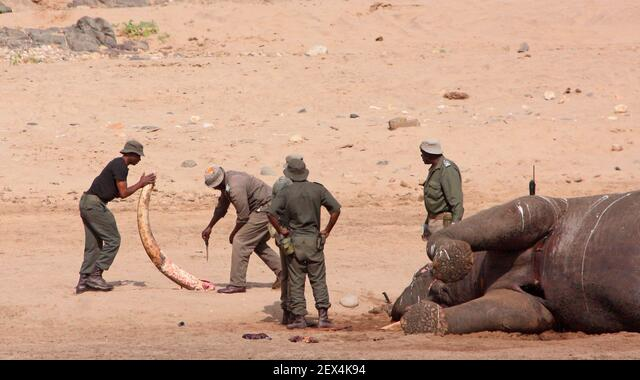

In [53]:
PIL.Image.open(ranger_df.iloc[31, :]['image_path'])

# 2. Zero shot object detection

In [56]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax), c in zip(scores, labels, boxes, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=c, linewidth=3))
        label = f"{label}: {score:0.2f}"
        ax.text(xmin, ymin, label, fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [59]:
from transformers import pipeline

checkpoint = "google/owlv2-base-patch16-ensemble"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection")

image = PIL.Image.open(ranger_df.iloc[31, :]['image_path'])
predictions = detector(
    image,
    candidate_labels=["poacher", "elephant", "rhino"],
)

# predictions

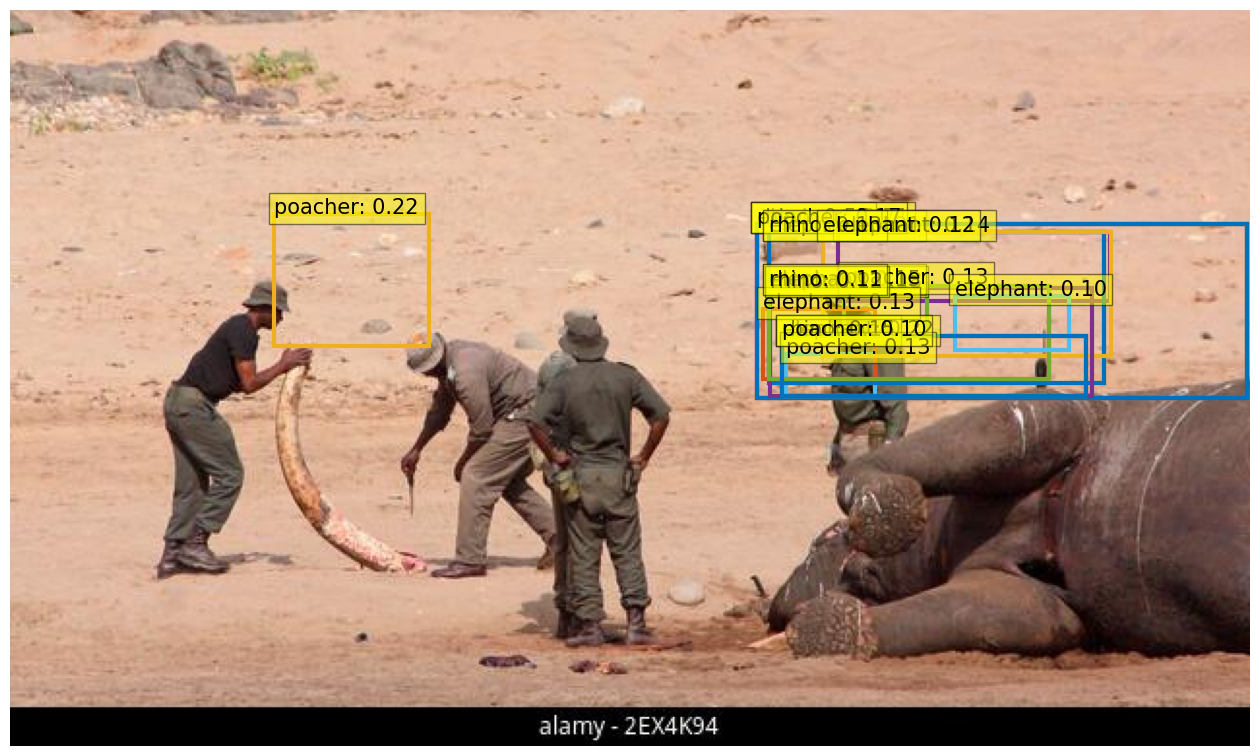

In [60]:
scores, labels, boxes = [], [], []
for result in predictions:
    # if result['score'] < 0.25:
    scores.append(result['score'])
    labels.append(result['label'])
    boxes.append(tuple(result['box'].values()))

plot_results(image, scores, labels, boxes)

In [61]:
# np.unique(labels, return_counts=True)[0].tolist() == []
labels = np.unique(labels, return_counts=True)[0].tolist()
counts = np.unique(labels, return_counts=True)[1].tolist()

target = {l: c for l,c in zip(labels, counts)}

if target != {}:
    print("Alert!!!")
    print(f"Number of poacher detections: {target['poacher']}")
else:
    print("Animals are safe. No poachers detected")

Alert!!!
Number of poacher detections: 1


In [23]:
np.unique(labels, return_counts=True)

(array([], dtype=float64), array([], dtype=int64))

In [24]:
# target = {}
# for i, (l,c) in enumerate(zip(labels, counts)):
#     target[l] = c

In [25]:
target

{}